In [1]:
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
import logging
from dataset import DataloaderImg, GreyToRGB, NormalizeVolume
from torch import optim
import torchvision.transforms.v2 as tfms
from tqdm import tqdm

plt.ion()  # interactive mode

# install pytorch correctly
# https://discuss.pytorch.org/t/torch-cuda-is-not-available/74845/11

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
logging.basicConfig(
    level=logging.INFO,
)
# install cuda driver ubuntu
# https://ubuntu.com/server/docs/nvidia-drivers-installation

cuda


In [2]:
# https://pytorch.org/docs/stable/cuda.html
# torch.cuda.is_initialized()

if torch.cuda.is_available():
    current_device = torch.cuda.current_device()
    print(f"Current cuda device: {torch.cuda.get_device_name(current_device)}")

Current cuda device: NVIDIA RTX A2000


In [3]:
# script for segmentation
# https://github.com/mateuszbuda/brain-segmentation-pytorch

In [69]:
# help in loading images
# https://discuss.pytorch.org/t/how-to-load-all-the-nii-from-the-directory-without-augmentation-using-pytorch-dataloader/60938/3
root_dir = "/media/MeMoSLAP_Subjects/derivatives/automated_electrode_extraction"  #!NOTE: delete "/train" for all subjects

custom_transforms = [NormalizeVolume(), GreyToRGB()]
transforms = [tfms.RandomRotation(180)]
n_validation = 4
# full_dataset = Dataloder_img('C:/Users/Ali ktk/.spyder-py3/dataloader/data/train/1', 'C:/Users/Ali ktk/.spyder-py3/dataloader/data/train/1/ADNI_136_S_0300_MR_MPR__GradWarp__B1_Correction__N3__Scaled_Br_20080529142830882_S50401_I107759.nii' ,tfms.Compose([tfms.RandomRotation(180).tfms.ToTensor()]))
train_dataset = DataloaderImg(
    root_dir,
    subset="train",
    validation_cases=n_validation,
    custom_transforms=custom_transforms,
    transforms=transforms,
)
validation_dataset = DataloaderImg(
    root_dir,
    subset="validation",
    validation_cases=n_validation,
    custom_transforms=custom_transforms,
    transforms=transforms,
)

loader = DataLoader(train_dataset, batch_size=10, shuffle=True)

In [65]:
def show_batch(img_batch, mask_batch, ncols=3):
    """
    Plot all images and masks of a batch as subplots with masks overlayed in red and opacity
    """

    n_img = len(img_batch)

    n_axs = n_img + (ncols - (n_img % ncols))

    fig, axs = plt.subplots(
        int(n_axs / ncols), ncols, figsize=(15, 5 * int(n_axs / ncols))
    )

    for img, mask, ax in zip(img_batch, mask_batch, axs.flatten()):
        ax.imshow(img.permute(1, 2, 0))
        ax.imshow(mask.squeeze(), alpha=0.3, cmap="Reds")

    plt.show()

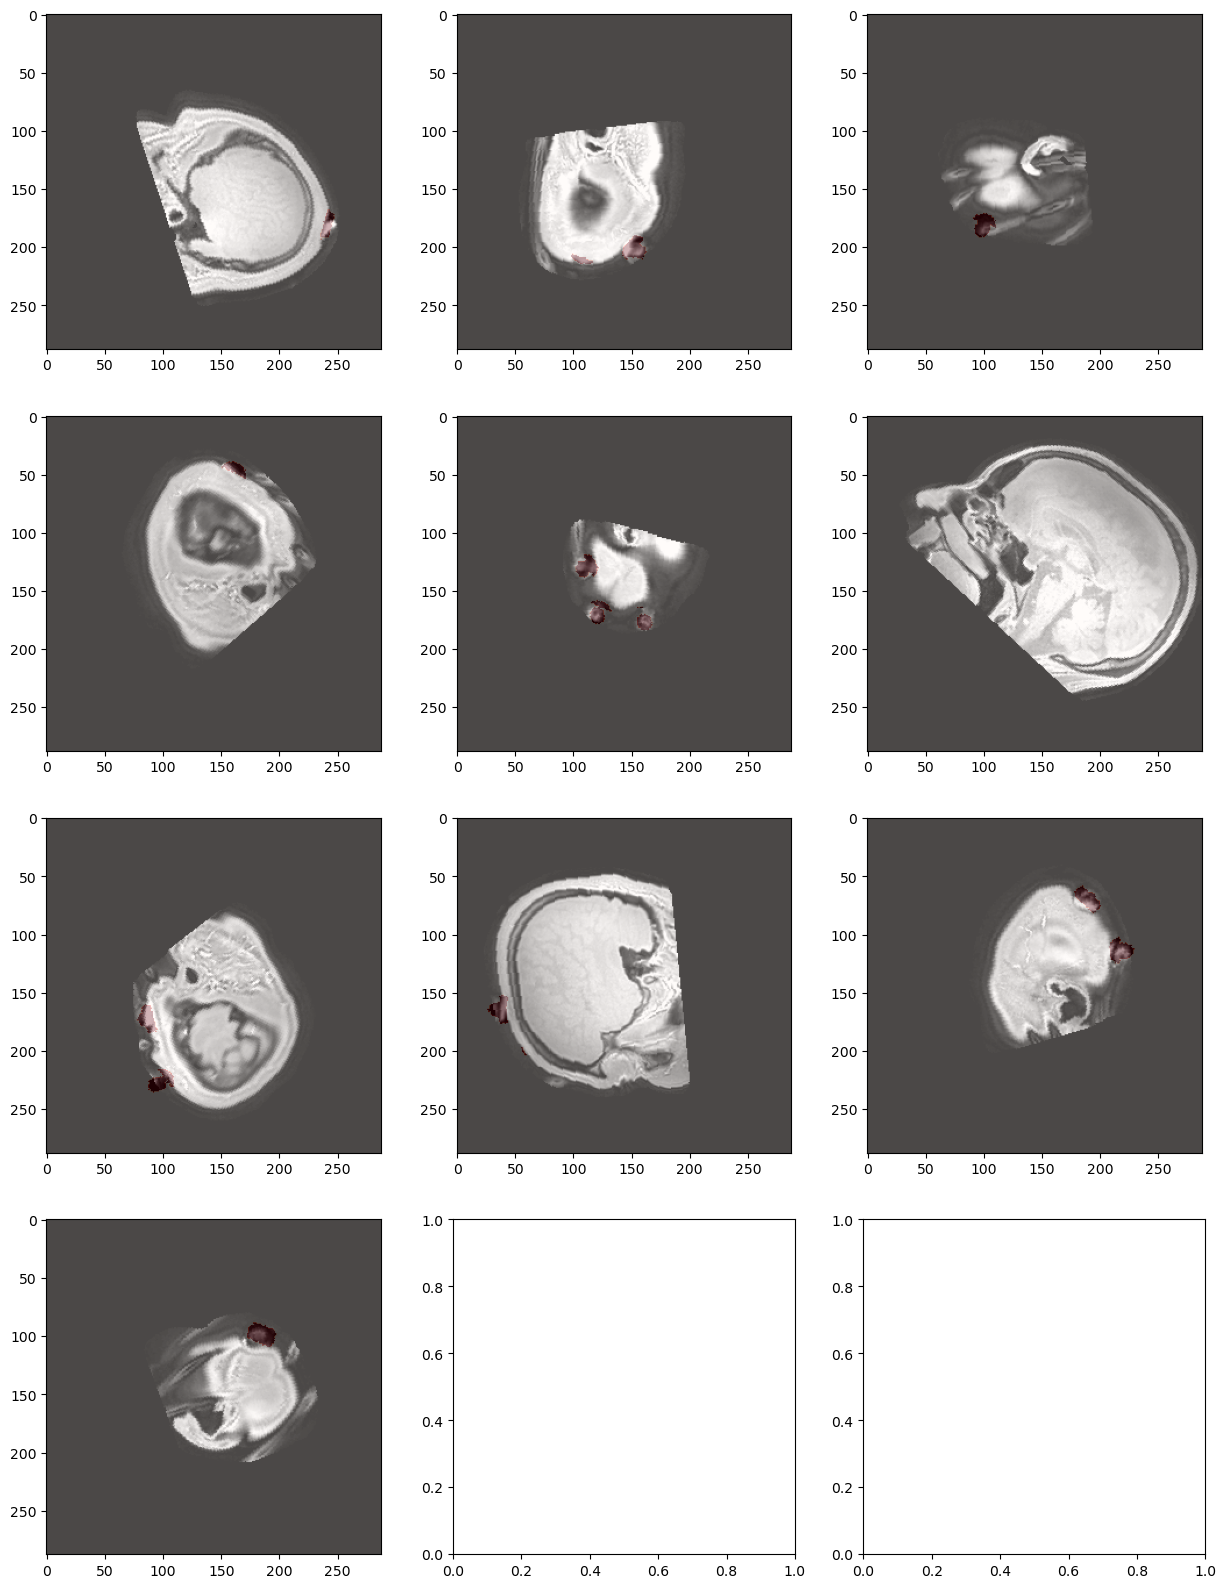

In [68]:
train_img, train_mask = next(iter(loader))
show_batch(train_img, train_mask)

In [ ]:
unet = torch.hub.load(
    "mateuszbuda/brain-segmentation-pytorch",
    "unet",
    in_channels=3,
    out_channels=1,
    init_features=32,
    pretrained=False,
)

In [ ]:
import torch.nn as nn


class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()
        self.smooth = 1.0

    def forward(self, y_pred, y_true):
        assert y_pred.size() == y_true.size()
        y_pred = y_pred[:, 0].contiguous().view(-1)
        y_true = y_true[:, 0].contiguous().view(-1)
        intersection = (y_pred * y_true).sum()
        dsc = (2.0 * intersection + self.smooth) / (
            y_pred.sum() + y_true.sum() + self.smooth
        )
        return 1.0 - dsc

In [ ]:
unet.to(device)

batch_size = 3  # todo: increase
epochs = 10  # todo: increase

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)

loaders = {"train": train_loader, "valid": valid_loader}

dsc_loss = DiceLoss()
best_validation_dsc = 0.0

optimizer = optim.Adam(unet.parameters(), lr=1e-4)  # todo: whats lr?

loss_train = []
loss_valid = []

step = 0

for epoch in tqdm(range(epochs), total=epochs):
    validation_pred = []
    validation_true = []

    phase = "train"

    for i, data in enumerate(loaders[phase]):
        x, y_true = data
        x, y_true = x.to(device, dtype=torch.float), y_true.to(device)

        optimizer.zero_grad()

        with torch.set_grad_enabled(phase == "train"):
            y_pred = unet(x)
            loss = dsc_loss(y_pred, y_true)

            if phase == "valid":
                ...

            if phase == "train":
                loss_train.append(loss.item())
                loss.backward()
                optimizer.step()

        if phase == "train" and (step + 1) % 10 == 0:
            print(
                f"Epoch [{epoch}/{epochs}], Step [{step}/{len(train_loader)}], Loss: {loss.item():.4f}"
            )
    if phase == "valid":
        ...

print("Best validation mean DSC: {:.4f}".format(best_validation_dsc))

In [ ]:
plt.imshow(y_pred[1][0].cpu().detach().numpy())

In [ ]:
plt.imshow(y_true[1][0].detach().cpu().numpy())

In [ ]:
y_true.size()